<a href="https://colab.research.google.com/github/fernandovieira1/ML-e-DS-com-Python-de-A-a-Z/blob/master/PARTE_7_classificacao_sentimentos_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#!pip install -U spacy
!python3 -m spacy download pt

In [2]:
import pandas as pd
import numpy as np

import spacy
import string
import random

import seaborn as sns

**Etapa 1: Carregamento da base de dados**

In [3]:
base_dados = pd.read_csv('/content/base_treinamento.txt', encoding='utf-8')

In [4]:
base_dados.shape

(196, 2)

In [5]:
base_dados

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria
...,...,...
191,estou chocado e amedrontado com este assassina...,medo
192,é preciso afugenta com ímpeto este medo do inf...,medo
193,políticos usam suas forças para afugentar e am...,medo
194,o objetivo disso e apenas me amedrontar mais,medo


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


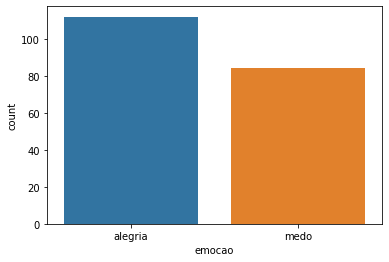

In [6]:
sns.countplot(base_dados['emocao'], label='Contagem')

**Etapa 2: Pré-processamento**

In [7]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS

In [9]:
pln = spacy.load('pt')

In [10]:
pln

In [11]:
def preprocessamento(texto):
  texto = texto.lower()
  documento = pln(texto)

  lista = []
  for token in documento:
    #lista.append(token.text) # tokenização
    lista.append(token.lemma_) # lematização

  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
  lista = ' '.join(str(elemento) for elemento in lista if not elemento.isdigit() )

  return lista




In [12]:
teste = preprocessamento('Estou aprendendo 10 200 25 preprocessamento de linguagem natural, curso em Curitiba')
teste

'aprender preprocessamento linguagem natural cursar curitiba'

In [13]:
# Limpeza

In [14]:
# Passar a função para cada linha do df base_dados
base_dados.head(10)

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria
5,adoro seu cabelo macio,alegria
6,adoro a cor dos seus olhos,alegria
7,somo tão amáveis um com o outro,alegria
8,sinto uma grande afeição por ele,alegria
9,quero agradar meus filhos,alegria


In [15]:
base_dados['texto'] = base_dados['texto'].apply(preprocessamento)

In [16]:
base_dados.head(10)

,texto,emocao
0,trabalhar agradável,alegria
1,gostar ficar o aconchegar,alegria
2,o adesão o o cursar hoje,alegria
3,admirar,alegria
4,adorar comer,alegria
5,adorar cabelar maciar,alegria
6,adorar o cor olho,alegria
7,somar amável o outro,alegria
8,sentir umar afeição,alegria
9,querer agradar filho,alegria


In [17]:
# Tratamento da classe

In [18]:
# O df deve estar nesta estrutura
exemplo_base_dados = [["este trabalho é agradável", {"ALEGRIA": True, "MEDO": False}],
                      ["este lugar continua assustador", {"ALEGRIA": False, "MEDO": True}]]

In [19]:
type(exemplo_base_dados)

list

In [20]:
exemplo_base_dados[0]

['este trabalho é agradável', {'ALEGRIA': True, 'MEDO': False}]

In [21]:
exemplo_base_dados[0][0]

'este trabalho é agradável'

In [22]:
exemplo_base_dados[1]

['este lugar continua assustador', {'ALEGRIA': False, 'MEDO': True}]

In [23]:
type(exemplo_base_dados[0][1])

dict

In [24]:
# início da reorganização

In [25]:
base_dados_final = []
i = 0

for texto, emocao in zip(base_dados['texto'], base_dados['emocao']):
  #print(texto, emocao)
  if emocao == 'alegria':
    dic = ({'ALEGRIA': False, 'MEDO': True})

  base_dados_final.append([texto, dic.copy()])

In [26]:
len(base_dados_final)

196

In [27]:
base_dados_final[0]

['trabalhar agradável', {'ALEGRIA': False, 'MEDO': True}]

In [28]:
base_dados_final[0][0]

'trabalhar agradável'

In [29]:
base_dados_final[0][1]

{'ALEGRIA': False, 'MEDO': True}

In [30]:
type(base_dados_final[0][1])

dict

In [31]:
#base_dados_final

**Etapa 3: Criação do classificador**

In [32]:
modelo = spacy.blank('pt')

categorias = modelo.create_pipe('textcat') # texto categórico
categorias.add_label('ALEGRIA')
categorias.add_label('MEDO')

modelo.add_pipe(categorias)

historico = []


**Etapa 4: Treinamento**

In [37]:
modelo.begin_training()

for epoca in range(1000):
  random.shuffle(base_dados_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_final, 30): # pega 30 registros por vez e submete à rede neural
      textos = [modelo(texto) for texto, entities in batch]
      annotations = [{'cats': entities} for texto, entities in batch]
      modelo.update(textos, annotations, losses=losses)
  if epoca % 100 == 0:
    print(losses)
    historico.append(losses)

{'textcat': 0.0007159823309557112}
{'textcat': 8.552717561949308e-11}
{'textcat': 7.11046581856889e-11}
{'textcat': 6.467540695706542e-11}
{'textcat': 6.327046742429787e-11}
{'textcat': 6.400807705045364e-11}
{'textcat': 1.2989173668945253e-10}
{'textcat': 9.1789065063963e-11}
{'textcat': 8.677346428204169e-11}
{'textcat': 7.220585240830246e-11}


In [38]:
historico_loss = []

for i in historico:
  historico_loss.append(i.get('textcat'))

In [39]:
historico_loss = np.array(historico_loss)
historico_loss

array([7.15982331e-04, 8.55271756e-11, 7.11046582e-11, 6.46754070e-11,
       6.32704674e-11, 6.40080771e-11, 1.29891737e-10, 9.17890651e-11,
       8.67734643e-11, 7.22058524e-11])

In [40]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Erro')

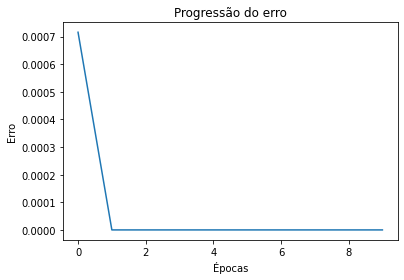

In [41]:
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [42]:
modelo.to_disk('modelo')

**Etapa 5: Teste**

In [43]:
modelo_carregado = spacy.load('/content/modelo')
modelo_carregado

In [45]:
texto_positivo = 'Eu adoro a cor dos seus olhos'

In [46]:
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'adorar o cor olho'

In [47]:
previsao = modelo_carregado(texto_positivo)
previsao

adorar o cor olho

In [48]:
previsao.cats

{'ALEGRIA': 4.539786823443137e-05, 'MEDO': 0.9999545812606812}

In [49]:
texto_negativo = 'estou com medo dele'

In [50]:
previsao = modelo_carregado(texto_negativo)
previsao

estou com medo dele

In [51]:
previsao.cats

{'ALEGRIA': 0.00013747152115684003, 'MEDO': 0.9999545812606812}

**Etapa 6: Avaliação do modelo**

In [52]:
previsoes = []

for texto in base_dados['texto']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes

In [54]:
previsoes_final = []

for previsao in previsoes:
  if previsao['ALEGRIA'] > previsao['MEDO']:
    previsoes_final.append('alegria')
  else:
    previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final) 

In [ ]:
previsoes_final

In [ ]:
respostas_reais = base_dados['emocao'].values
respostas_reais

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [58]:
accuracy_score(respostas_reais, previsoes_final)

0.42857142857142855

In [59]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[  0, 112],
       [  0,  84]])

Avaliação na base teste

In [60]:
base_dados_teste = pd.read_csv('/content/base_teste.txt', encoding='utf-8')
base_dados_teste


,texto,emocao
0,não precisei pagar o ingresso,alegria
1,se eu ajeitar tudo fica bem,alegria
2,minha fortuna ultrapassará a sua,alegria
3,sou muito afortunado,alegria
4,é benéfico para todos esta nova medida,alegria
...,...,...
79,fui notificado e estou com medo de perder a gu...,medo
80,estou angustiada com meus filhos na rua,medo
81,e abominável o que fazem com os animais,medo
82,foi terrível o tigre quase o matou,medo


In [61]:
base_dados_teste['texto'] = base_dados_teste['texto'].apply(preprocessamento)

In [62]:
base_dados_teste.head()

,texto,emocao
0,precisar pagar o ingressar,alegria
1,ajeitar ficar,alegria
2,fortuna ultrapassar o suar,alegria
3,afortunar,alegria
4,benéfico parir medir,alegria


In [63]:
previsoes = []

for texto in base_dados_teste['texto']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [64]:
previsoes_final = []

for previsao in previsoes:
  if previsao['ALEGRIA'] > previsao['MEDO']:
    previsoes_final.append('alegria')
  else:
    previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final) 

In [ ]:
respostas_reais = base_dados_teste['emocao'].values
respostas_reais

In [66]:
accuracy_score(respostas_reais, previsoes_final)

0.42857142857142855

In [67]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[ 0, 48],
       [ 0, 36]])